# Flower Classification using tf.keras (CNN, Data Augmentation, Dropout)


# Necessary Imports


*   numpy
*   os, glob, shutil (for file retrieval)
*   matplotlib.pyplot (for viewing images, graphing)
*   tensorflow.keras
       - models.Sequential (to build the model)
       - layers.Dense, Conv2D, Flatten, Dropout, MaxPooling2D (to build model)
       - preprocessing.image.ImageDataGenerator (for image augmentation)




In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

In [ ]:
URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(origin=URL,
                                   fname='flower_photos.tgz',
                                   untar=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'flower_photos')

228818944/228813984 [==============================] - 1s 0us/step


In [ ]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

The flowers dataset directory has this structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

The following code will add folders for training and validation data to the existing directory, and move the images there. The original folders will remain, but be empty. In the end, the dataset directory will have this structure:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>


In [ ]:
for cl in classes:
  imgs_path = os.path.join(data_dir, cl) #go into dir with name of flower
  imgs = glob.glob(imgs_path + '/*.jpg') #find all pics in that dir (pic if ends in jpg)
  print(f"{cl}: {len(imgs)} Images")
  train, val = imgs[:round(len(imgs) * 0.8)], imgs[round(len(imgs) * 0.8):] #80-20 split into train/val datasets

  for t in train:
    if not os.path.exists(os.path.join(data_dir, 'train', cl)): #if a path of format flower_photos/train/[class_name] doesn't exist, make one
      os.makedirs(os.path.join(data_dir, 'train', cl)) #use makedirs to create train/[class_name] (mkdir would only create [class_name])
    shutil.move(t, os.path.join(data_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(data_dir, 'val', cl)): #similar process for validation data
      os.makedirs(os.path.join(data_dir, 'val', cl)) 
    shutil.move(v, os.path.join(data_dir, 'val', cl))


roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [ ]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Data Augmentation

One reason overfitting can occur is an small amount of training data. One way to generate more training data is to augment the training dataset. Data augmentation yields more training examples by augmenting the existing samples via many random transformations (i.e. brightness shifts, zooms, rotations, etc.) that produce believable-looking images. The goal is that at training time, the model will never see the exact same image twice. This, in turn, produces a more robust model that can generalize better.

**tf.keras**'s **ImageDataGenerator** is used for this augmentation.

In [ ]:
BATCH_SIZE = 100
IMG_SHAPE = 150

The following is a function that will display augmented images to make it easier to see the results of the random augmentations.

In [ ]:
def PlotImages(imgs):
  dim = 3 #for a 3x3 of images
  plt.figure(figsize=(10, 10))
  for i in range(dim**2):
    plt.subplot(dim, dim, i+1)
    plt.imshow(imgs[i])

## Types of Augmentation Used

The ImageDataGenerator will rescale images by 255 (i.e. convert each pixel value to a value from 0 to 1), and apply combinations of these transformations randomly:

- 45 degree rotation
- zoom of up to 50%
- horizontal flip
- width shift of 0.15
- height shift of 0.15
- brightness shift of +/- 50%


In [ ]:
img_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    height_shift_range=0.15,
    width_shift_range=0.15,
    brightness_range=(0.5, 1.5),
    fill_mode='wrap'    
)

train_data_gen = img_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    shuffle=True,
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.


Now, visualize what a single image would look like 9 times after undergoing random transformations.

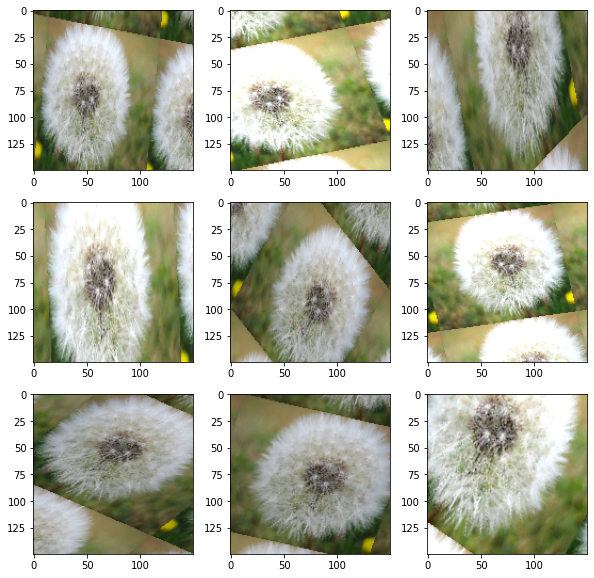

In [ ]:
viz_imgs = [train_data_gen[0][0][0] for i in range(9)]
PlotImages(viz_imgs)

The following code creates a validation image generator (no augmentation, because the point is to test how well the model predicts *real* data).

In [ ]:
img_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = img_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=val_dir,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='sparse')

Found 735 images belonging to 5 classes.


# Model Creation


The model used to classify the images will be a convolutional neural network (CNN) of 3 convolution blocks. Each convolution block will contain a convolution layer followed by a max-pooling layer. The first block will have 16 filters, the second 32 filters, and the third 64 filters. All filters will be 3 x 3, and all max-pool layers will have a pool size of 2 x 2.

The convolutional blocks will be followed by a flatten layer (that will take the result of the convolutions and "flatten" it into a 1D array of data points). This, in turn, will be followed by a fully-connected Dense layer of 512 units. Finally, the model will use the **softmax** activation function to output class probabilities. The other layers will use the **relu** activation function.

Another method of combatting overfitting, known as Dropout, will also be used. Dropout is the "shutting down" of a certain percentage of neurons during training. This prevents a situation from occurring where just a few neurons hold the greatest weight, and thus, perform the bulk of classification. Dropout layers of 20% will be added where appropriate.


In [ ]:
model = Sequential([
   Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
   MaxPooling2D(pool_size=(2,2)),

   Conv2D(32, (3,3), padding='same', activation='relu'),
   MaxPooling2D(pool_size=(2,2)),

   Conv2D(64, (3,3), padding='same', activation='relu'),
   MaxPooling2D(pool_size=(2,2)),

   Flatten(),

   Dropout(0.2),
   Dense(512, activation='relu'),

   Dropout(0.2),
   Dense(5, activation='softmax')                 
])

The following code compiles the model. ADAM is the industry-standard optimizer, sparse-categorical-crossentropy is used for multi-class classification (no one-hot encoding), and the model needs to keep track of accuracy over epochs.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model Training


In [ ]:
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.02)

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/100
30/30 [==============================] - 31s 821ms/step - loss: 2.8175 - accuracy: 0.2272 - val_loss: 1.5415 - val_accuracy: 0.2707
Epoch 2/100
30/30 [==============================] - 24s 807ms/step - loss: 1.4304 - accuracy: 0.3518 - val_loss: 1.1975 - val_accuracy: 0.4993
Epoch 3/100
30/30 [==============================] - 24s 803ms/step - loss: 1.2447 - accuracy: 0.4595 - val_loss: 1.1297 - val_accuracy: 0.5088
Epoch 4/100
30/30 [==============================] - 24s 803ms/step - loss: 1.1727 - accuracy: 0.4938 - val_loss: 1.1574 - val_accuracy: 0.5197
Epoch 5/100
30/30 [==============================] - 24s 806ms/step - loss: 1.1800 - accuracy: 0.5179 - val_loss: 1.0076 - val_accuracy: 0.6327
Epoch 6/100
30/30 [==============================] - 24s 805ms/step - loss: 1.0947 - accuracy: 0.5589 - val_loss: 1.0066 - val_accuracy: 0.6177
Epoch 7/100
30/30 [==============================] - 24s 805ms/step - loss: 1.0843 - accuracy: 0.5644 - val_loss: 0.9800 - val_accuracy:

# Loss and Accuracy Plotting


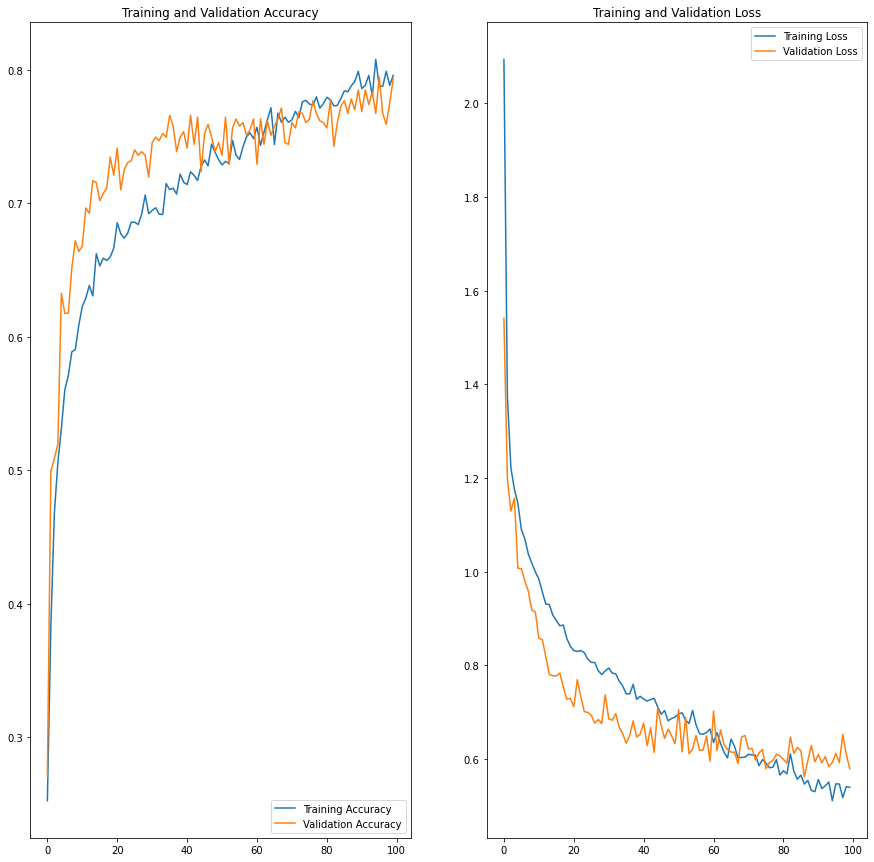

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,15))
x_epochs = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(x_epochs, acc, label='Training Accuracy')
plt.plot(x_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(x_epochs, loss, label='Training Loss')
plt.plot(x_epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()

# Model Testing

Here, the model will be tested on a single example of an image of a tulip.


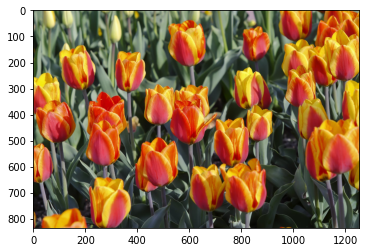

In [ ]:
tester = tf.keras.preprocessing.image.load_img('tulip_test.jpg')
plt.imshow(tester)

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(tester)
input_arr = np.array([input_arr])  # Convert single image to a batch.

resized = tf.image.resize(input_arr, (150, 150))
predictions = model.predict(resized)

guess = predictions.argmax()
print(classes[guess])

tulips
